In [ ]:
# Wikipedia App

## "Reduce" with One Mean

__Conclusion__: _It works with RidgeCV, alpha=0.1_

In [1]:
try:
    initialized
except NameError:
    ## Matplotlib configuration
    %matplotlib inline
    initialized = True

from math import ceil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.linear_model import RidgeCV, LinearRegression
from lib.wikipedia import DataFrameBuilder
from lib import Humanizer, Plotter, Model, OneManyModel, TwoMeanModel, Outlier, ExperimentInfo, TaskMeanModel
from mynotebook import *

df_builder = DataFrameBuilder()

## Wikipedia Application

### Target

,input size (GiB),workers,outliers,samples,available
0,45,4,0,30,30
1,45,8,3,30,27
2,45,16,1,30,29
3,45,32,0,30,30
4,45,64,7,30,23


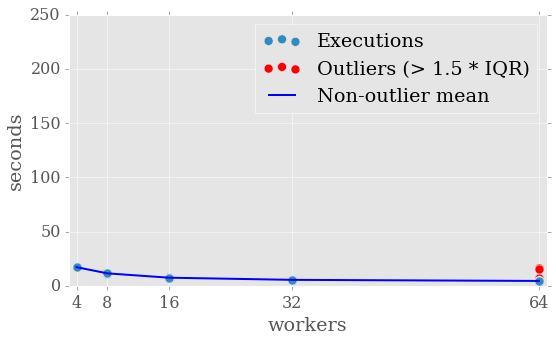

Total target application duration using the complete dataset (45 GB).


In [2]:
target_out = df_builder.get_target_df(stage=1)
humanizer = Humanizer(size=Humanizer.SIZE_GIB)
plotter = Plotter((3, 65), (0, 250))
caption = 'Total target application duration using the complete dataset (45 GB).'
target = process_outliers(target_out, humanizer, plotter, caption)

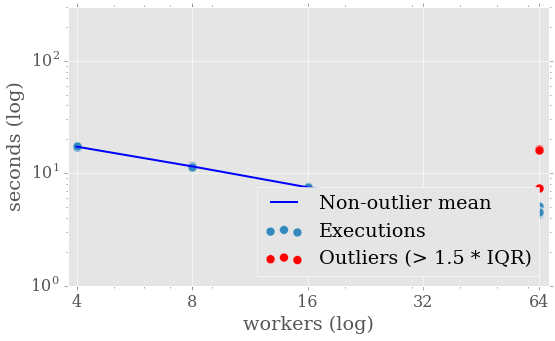

The same as above in log-log scale.


In [3]:
plotter = Plotter((3.8, 68), (1, 300), logx=True, logy=True, loc='lower right')
target_out['outlier'] = Outlier.is_outlier(target_out)
plotter.plot_outliers(target_out)
print('The same as above in log-log scale.')

### "Map" stage

In [4]:
exp_info = ExperimentInfo(ExperimentInfo.SS2, 2, 128 * 1024 ** 2)
caption = 'Durations of the first tasks using 1-GB input data.'
prof_many_first_out, prof_many_nonfirst_out = df_builder.get_strong_scaling_tasks_df(2, stage=1, threads=exp_info.threads)
prof_many_out = pd.concat([prof_many_first_out, prof_many_nonfirst_out])

,workers,input,ms,outlier
113,1,1073741798,30,False
482,1,1073741798,36,False
2920,2,1073741798,33,False


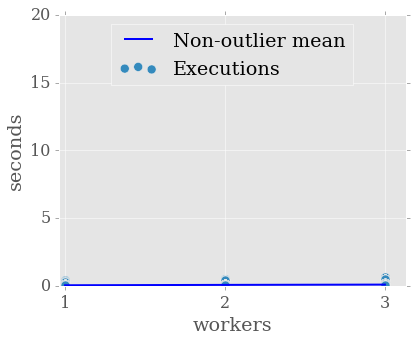

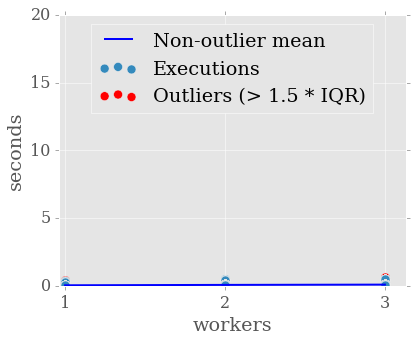

In [5]:
humanizer = Humanizer(size=Humanizer.SIZE_MIB)
plotter = Plotter((0.96, 3.13), (0, 20), logx=False, logy=False, loc='upper center', figsize=(6, 5))

prof_many_out['outlier'] = [False] * len(prof_many_out)
display(prof_many_out.sample(3))
plotter.plot_outliers(prof_many_out)

# Process outliers separately for first and nonfirst tasks
prof_many_first_out['outlier'] = Outlier.is_outlier(prof_many_first_out)
prof_many_nonfirst_out['outlier'] = Outlier.is_outlier(prof_many_nonfirst_out)
prof_many_out = pd.concat([prof_many_first_out, prof_many_nonfirst_out])
plotter.plot_outliers(prof_many_out)

prof_many = prof_many_out[~prof_many_out.outlier].drop('outlier', axis=1)

In [6]:
prof = prof_many
prof = prof.groupby(['workers', 'input']).mean().reset_index()

display(prof.sample(3))
#model = Model(RidgeCV(normalize=True), features=['workers'], ycol='ms', degree=2, use_log=False)
model = Model(LinearRegression(), features=['workers'], ycol='ms', use_log=False)
display(model.fit_score(prof))
linreg = model.get_linreg()
display(linreg.intercept_, linreg.coef_)

model_many = model

,workers,input,ms
1,2,1073741798,66.28
0,1,1073741798,37.91
2,3,1073741798,87.06


[0.02868406626346996,
 ((1, 1073741798), 0.03336055571039699),
 ((2, 1073741798), 0.03816413446448),
 ((3, 1073741798), 0.01452750861553289)]

14.603428900345975

array([ 24.57516164])

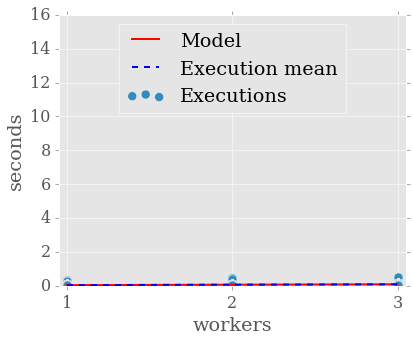

In [7]:
model = model_many
prof = prof_many

plotter = Plotter((0.95, 3.05), (0, 16), loc='upper center', figsize=(6, 5))
plotter.plot_model(model, prof)

In [8]:
exp_info = ExperimentInfo(ExperimentInfo.ONE, 2, 128 * 1024**2)
prof_one_first_out, prof_one_nonfirst_out = df_builder.get_1VM_tasks_df(stage=1, threads=exp_info.threads)
prof_one_first = remove_outliers(prof_one_first_out[prof_one_first_out.input > 200 * 1024**2])
prof_one_nonfirst = remove_outliers(prof_one_nonfirst_out[prof_one_nonfirst_out.input > 200 * 1024**2])
prof_one = pd.concat([prof_one_first, prof_one_nonfirst])

In [9]:
prof = prof_one
prof = prof.groupby(['workers', 'input']).mean().reset_index()

model_one = Model(LinearRegression(), features=['input'], ycol='ms', use_log=False)
model_one.fit(prof_one)
display(task_model.score(prof_one))
plotter = Plotter()
plotter.plot_model(model_one, prof_one)

NameError: name 'task_model' is not defined

In [ ]:
model